## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from imutils import paths 
import shutil 

from fastai.vision import *
from fastai.metrics import error_rate

## Train Test Split

In [22]:
original_data_path = 'breast-histopathology-images/original_data'
refined_data_path = 'breast-histopathology-images/fastai_data'     # for training, testing, validataion data
train_path = os.path.sep.join([refined_data_path, 'train'])
val_path = os.path.sep.join([refined_data_path, 'valid'])
train_split = 0.8   # amount for training
image_paths = list(paths.list_images(original_data_path))   
random.seed(2)
random.shuffle(image_paths)
split = int(len(image_paths) * train_split)
new_train_path = image_paths[:split]
new_val_path = image_paths[split:]
datasets = [('train', new_train_path, train_path),
            ('val', new_val_path, val_path)]

for(dType, image_paths, baseOutput) in datasets:
    print('building'.format(dType))
    if not os.path.exists(baseOutput):
        os.makedirs(baseOutput)
    for inputPath in image_paths:
        filename = inputPath.split(os.path.sep)[-1]     
        label = filename[-5:-4]                         
        labelPath = os.path.sep.join([baseOutput, label])   
        if not os.path.exists(labelPath):
            os.makedirs(labelPath)                      
        path = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, path) 

building
building


## Data Augmentation

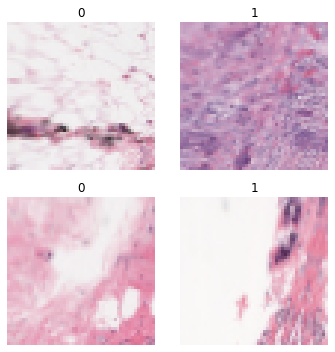

In [5]:
bs = 64
path = 'breast-histopathology-images/fastai_data' 
tfms = get_transforms(max_rotate=20,
                      flip_vert=True,
                      max_zoom=1.1,
                      max_warp=0.4,
                     max_lighting=None)
data = ImageDataBunch.from_folder(path, valid='valid', ds_tfms=tfms, size=50, bs=bs).normalize(imagenet_stats)
data.show_batch(rows=2, figsize=(5,5))

## Training the model

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,time
0,0.332154,0.332136,0.139789,46:31
1,0.324127,0.291069,0.122746,46:00
2,0.317222,0.280076,0.118872,47:10
3,0.293564,0.272945,0.115017,47:22
4,0.289183,0.269477,0.113431,46:49
5,0.276976,0.267055,0.111918,47:23
6,0.283544,0.266649,0.111648,47:46


In [10]:
learn.save('stage-1')

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


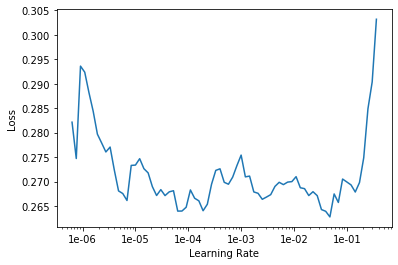

In [11]:
learn.recorder.plot()

In [14]:
learn.load('stage-1');
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.266075,0.267984,0.111269,49:01
1,0.263636,0.253164,0.107324,44:32
2,0.257479,0.244172,0.103162,44:40
3,0.252569,0.242025,0.102820,44:27


## Model Interpretation

*The model reaches a 90% accuracy (0.1 error rate). To further understand the model and to not treat it as a black-box, we will further try to interpret the results.*

We can see that the model has a True Negative Rate of 0.9370 and a True Positive rate of 0.7969.

In [61]:
from fastai.callbacks.hooks import *

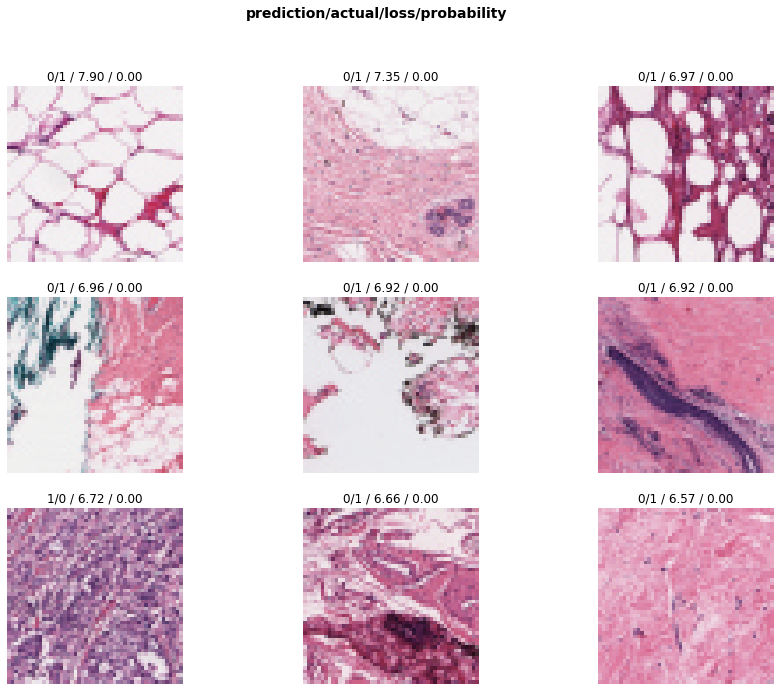

In [77]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

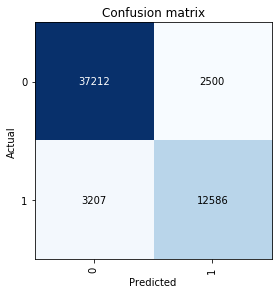

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Category 1

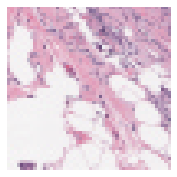

In [70]:
idx=46774
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [78]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

m = learn.model.eval();
hook_a,hook_g = hooked_backward()

acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 2, 2])

The activations heatmap clearly shows that the model found the tumor cells in the top-right of the image.

torch.Size([2, 2])


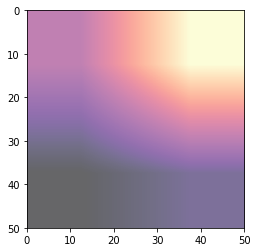

In [74]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    #xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,50,50,0),
              interpolation='bilinear', cmap='magma');

avg_acts = acts.mean(0)
print(avg_acts.shape)

show_heatmap(avg_acts)

In [76]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 25, 25]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 25, 25]         128        True      
______________________________________________________________________
ReLU                 [64, 25, 25]         0          False     
______________________________________________________________________
MaxPool2d            [64, 13, 13]         0          False     
______________________________________________________________________
Conv2d               [64, 13, 13]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 13, 13]         128        True      
______________________________________________________________________
ReLU                 [64, 13, 13]         0          False     
___________________________________________________